### Analyze the growth of the branches to caluclate apical branching ratio to see if they correspond to the same phenomena. 

In [1]:
#Imports needed
import numpy as np #For everything                              version 
import matplotlib.pyplot as plt #For visualisation              version 
import networkx as nx #For the graph                            version 
from pickle import load as pload #For loading the gpickle file  version 
from PIL import Image #For image management                     version 
from tqdm import tqdm #For nice loading bars                    version 
from declaration_tutti import load, treat_a_new_reseau, load_from_scratch
from fct_utils import prune,xy2t
from fct_analyse import arbre_genealogique_branches,color_by_time
#Our part:
from Reseau import Reseau,Brindille,Branche 
from scipy.optimize import curve_fit
from IPython.display import Image

reseau= load('M2WT_200616',"branched")
for b in reseau.branches:
        b.n2x = reseau.n2x
        b.n2y = reseau.n2y
        b.n2t = reseau.n2t

def abscisse_curviligne(branch)->np.ndarray:
    """
    Renvoie la liste des abscisses curvilignes des noeuds de la branche
    """
    pos = np.array([[branch.n2x[n],branch.n2y[n]] for n in branch.noeuds])
    abscisse = np.sqrt(np.sum((pos[1:,:]-pos[:-1,:])**2,axis=-1))
    abscisse = np.cumsum(abscisse)
    abscisse = np.insert(abscisse,0,0)
    return abscisse

def distance(nodo1 , nodo2, branch):
    list_ascisse = abscisse_curviligne(branch)
    nodo_1 = branch.noeuds.index(nodo1)
    nodo_2= branch.noeuds.index(nodo2)
    distance = list_ascisse[nodo_2] - list_ascisse[nodo_1]
    return distance

In [2]:
tau = 5 
for b in reseau.branches:
    starting_node = b.noeuds[0]
    starting_time = reseau.n2t[starting_node]
    DELTA = b.get_tstart() - starting_time
    if  DELTA  <= tau and DELTA > 0:       #there are some deltas< 0 ( a few, like 2 of them  vedi perchè) 
        b.nature = 'Apical'
    else: b.nature = 'Lateral' 

In [3]:
apicalBranching = [b.noeuds[0]  #tutti i nodi di inizio di branch apicali.
                       for b in reseau.branches 
                       if b.nature == "Apical"] 

## $\downarrow$ this is the normal code to get the apical sons belonging to apical/ lateral mothers, when the mother ends in fusion and the sons are born after the fusion of the mother. We take branching ratio datas for these branches BEFORE FUSION and after we compare it to the ones after fusion. 

#### stored in distances_dict_ap

In [4]:
# Initialize dictionaries to store distances and time differences for each 'b'
distances_dict_ap = {}
time_diffs_dict_ap = {}


# apical neighbors
for b in reseau.branches:
    if b.ending == 'Fusion?':                         
        vicini_out = reseau.neighborhood()[b.index]['out']  
        nodi_fuso = b.noeuds 
        t_fusione = b.get_tend()  
        nodo_fusione = b.noeuds[-1]  
        distances_dict_ap[b] = {}  
        time_diffs_dict_ap[b] = {} 
        
        for j in vicini_out:  
            starting_node = j.noeuds[0] 
            if starting_node in apicalBranching:
                if starting_node != nodo_fusione:  # If the starting node of the neighbor is the father of a lateral branch and is a node of no overlap 
                    # Calculate starting time as the time of the second element of the branchement  
                    starting_time = j.get_tstart()  
                    
                    if t_fusione <= starting_time: #<= t_fusione + 1:
                        if j != b: 
                            dis = distance(  starting_node,nodo_fusione, b)  
                            time_diff = starting_time - t_fusione
                            distances_dict_ap[b][j] = dis
                            time_diffs_dict_ap[b][j] = time_diff


## Follow apical branching born on the mothers that undergo fusion later on.  

* loop on **mums** of branchements **born after fusion** 
* Take apical sons born BEFORE fusion 
* **storing in deltas_Ls_dictionary**

* $\Delta L$ is the distance from the fusion node and the birth of the son 
* $\Delta T$  is the distance in time from the fusion node 

In [5]:
deltas_Ls_dictionary={}
vitas_mom_dict = {}    #per i tempi 
deltas = {}
distancess =[]
timess =[]
for b in distances_dict_ap.keys():                        #ciclo sulle mamme( ap o lateral che siano?) che finiscono MIB 
    t_fusione = b.get_tend() 
    t_start_mom = b.get_tstart()
    vicini_out = reseau.neighborhood()[b.index]['out'] 
    nodo_fusione = b.noeuds[-1]
    deltas_Ls_dictionary[b] = {} 
    deltas ={}  
    vita = t_fusione - t_start_mom
    for j in vicini_out:                            #prendo i vicini APICAL uscenti delle mamme
        starting_node = j.noeuds[0] 
        starting_time = j.get_tstart() 
        if starting_node in apicalBranching: 
            if t_fusione >=  starting_time:  #DI QUELLI CHE NASCONO PRIMA DELLA FUSIONE DELLA MAMMA 
                dis = distance( starting_node,nodo_fusione, b)    #NE CALCOLO LA DISTANZA DALLA FUZIONE 
                deltas_Ls_dictionary[b][j] = dis   
                vitas_mom_dict[b] = vita 
                distancess.append(distance(nodo_fusione, starting_node, b))
                timess.append( -t_fusione + starting_time ) 


dizT = deltas_Ls_dictionary.copy()
for b in dizT:
    if dizT[b] == {}:
       deltas_Ls_dictionary.pop(b)
    

In the structure deltas_Ls_dictionary it's stored the distances from mother fusion node of all the apical branches outgoing from the mother BEFORE the fusion of the latter. The structure is like:  {mamma1:{figlio1: distance1 , figlio2: distance2 ...}}

In [6]:
rates={}      #qui con rates intendiamo #apical branchings su quel ramo / tempo di vita del ramo? 
for b in deltas_Ls_dictionary:
    N = len(deltas_Ls_dictionary[b]) 
    life = vitas_mom_dict[b]
    
    rates[b] = N/life


C:\Users\alice\AppData\Local\Temp\ipykernel_8964\3607521244.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  rates[b] = N/life


Abbiamo calcolato il branching rate per ogni madre che presenta filgi nati dopo fusione. (SHOULD I CONSIDER MIB MOTHERS ? ) 

In [7]:
def abscisse_curviligne(b) -> (np.ndarray, float):
    """
    Renvoie la liste des abscisses curvilignes des noeuds de la branche
    et la longueur totale de la branche
    """
    pos = np.array([[b.n2x[n], b.n2y[n]] for n in b.noeuds])
    distances = np.sqrt(np.sum((pos[1:, :] - pos[:-1, :]) ** 2, axis=-1))
    total_length = np.sum(distances)
    abscisse = np.cumsum(distances)
    abscisse = np.insert(abscisse, 0, 0)
    return abscisse, total_length

def lengths(reseau):
     lens=[]
     lengths = {n: [] for n in reseau.branches}
     for b in reseau.branches: 
        value = abscisse_curviligne(b)[1]
        lengths[b].append(value)
     return lengths

lenghts_dic= lengths(reseau)
lens=[]
for l in lengths(reseau).values():
    if l[0] != 0:                           #ZEROS HAVE BEEN MANUALLY REMOVED
        lens.append(l[0])



#### ALSO IN THIS CASE, LET'S TAKE THE "MIBs" KIND OF BRANCHINGS. 

# Compute  branching rate per gli MIB (AFTER FUSION) 

In [8]:
# Prendo gli MIB 
v_ap = 45
times_MIB_dict={}
distances_MIB_dict = {}

for b in time_diffs_dict_ap.keys():
    times_MIB_dict[b] = {}
    distances_MIB_dict[b] = {}
    for j in time_diffs_dict_ap[b].keys(): 
        dist = distances_dict_ap[b][j]
        time = time_diffs_dict_ap[b][j]
        L_MIB = v_ap * (tau - time)
        if dist <= L_MIB:  
    
            times_MIB_dict[b][j] = time 
            distances_MIB_dict[b][j] = dist

In [9]:
# Extracting the values
values_dist = {key: list(value.values()) for key, value in distances_MIB_dict.items()}
values_timez = {key: list(value.values()) for key, value in times_MIB_dict.items()}
# Plotting

plt.plot(x_values , y_values_ap , label = 'Apical')

for key, value in values_dist.items():
    plt.scatter( values_timez[key] ,value )

plt.show()

NameError: name 'x_values' is not defined

In [10]:
rates_MIB={}      #qui con rates intendiamo #apical branchings su quel ramo / tempo di vita del ramo? 
for b in distances_MIB_dict:
    N = len(distances_MIB_dict[b])
    
    life=5
    rates_MIB[b] = N/life


ValueError: supplied range of [0.047619047619047616, inf] is not finite

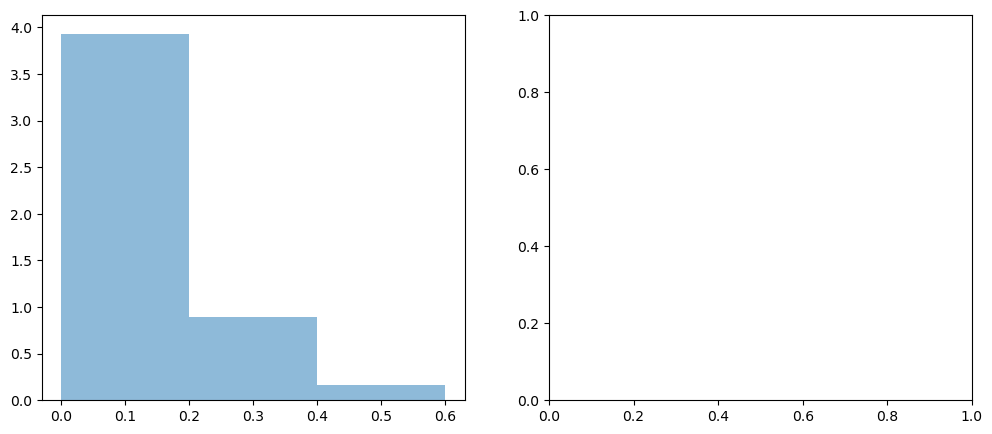

In [11]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot histograms
axs[0].hist(list(rates_MIB.values()), bins=3, density=True, label='MIB', alpha=0.5)
axs[0].hist(list(rates.values()), bins=5, density=True, label='Normal', alpha=0.5)
axs[0].set_title('Histograms')
axs[0].legend()

# Plot cumulative distributions
axs[1].hist(list(rates_MIB.values()), bins=50, density=True, histtype='step', cumulative=True, label='MIB', color='blue')
axs[1].hist(list(rates.values()), bins=5, density=True, histtype='step', cumulative=True, label='Normal', color='orange')
axs[1].set_title('Cumulative Distributions')
axs[1].legend()
axs[0].set_xlabel('Rates')
axs[1].set_xlabel('Rates')

plt.show()

In [ ]:
from scipy.stats import kstest
statistic, p_value = kstest(list(rates.values()),list(rates_MIB.values()) )
print("Kolmogorov-Smirnov test statistic:", statistic)
print("p-value:", p_value)

# CALCULATE BRANCHING RATE FOR GENERIC NOT FUSING BRANCHES (APICAL SONS) 

### In questo caso hai preso quelli che NON finiscono in fusione, ma prova anche a prendere sia quelli che finsicono in fusione che non al patto che gli apical siano considerati prima della fusione. 


### In this case you took all of branching NOT ending in fusion but we'll try as well to take also apical sons born on ANY mother 

In [ ]:

count_dict = {}
LIFE_dict = {}    #per i tempi 

for b in reseau.branches:                        #ciclo sulle mamme( ap o lateral che siano?) che finiscono MIB 
    if b.ending != 'Fusion?':
        vita = b.get_tend() - b.get_tstart()
        vicini_out = reseau.neighborhood()[b.index]['out'] 
        count = 0
        for j in vicini_out:  
            if vita > 0:#prendo i vicini APICAL uscenti delle mamme
                starting_node = j.noeuds[0] 
                starting_time = j.get_tstart() 
                if starting_node in apicalBranching: 
                    count += 1 
                count_dict[b] = count 
                LIFE_dict[b] = vita

In [ ]:
rates_not_fusion = {}
for j in count_dict.keys():   
    rates_not_fusion[j] = count_dict[j] / LIFE_dict[j]


In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot degli istogrammi per il primo grafico
axs[0].hist(list(rates_not_fusion.values()), bins=5, density=True)
axs[0].hist(list(rates_MIB.values()) , bins=3, density=True, label='MIB', alpha=0.5) 
axs[0].set_title('Branching rates of apical sons of non FUSION mothers')
axs[0].legend()
axs[0].set_xlabel('Rates')

# Plot delle distribuzioni cumulative per il secondo grafico
axs[1].hist(list(rates_not_fusion.values()), bins=30, density=True, histtype='step', cumulative=True)
axs[1].hist(list(rates_MIB.values()), bins=30, density=True, histtype='step', cumulative=True, label='MIB', color='orange')
axs[1].set_title('Cumulative distributions')
axs[1].legend()
axs[1].set_xlabel('Rates')

plt.show()


In [ ]:
statistic, p_value = kstest(list(rates_not_fusion.values()),list(rates_MIB.values()) )
print("Kolmogorov-Smirnov test statistic:", statistic)
print("p-value:", p_value)

## LET'S ALSO CONSIDER THE BRANCHING RATES OF ALL THE APICAL SONS BORN BEFORE THE FUSION OR THE EVOLUTION OF THE MOTHER 

In [ ]:

count_dict_all = {}
LIFE_dict_all = {}    #per i tempi 

for b in reseau.branches:                        #ciclo sulle mamme( ap o lateral che siano?) che finiscono MIB 
    
    vita = b.get_tend() - b.get_tstart()
    vicini_out = reseau.neighborhood()[b.index]['out'] 
    count = 0
    for j in vicini_out:  
        birth = j.get_tstart()
        if vita > 0:#prendo i vicini APICAL uscenti delle mamme
            if birth < b.get_tend(): #all the nodes born before the end of the mother 
                starting_node = j.noeuds[0] 
                starting_time = j.get_tstart() 
                if starting_node in apicalBranching: 
                    count += 1 
                count_dict_all[b] = count 
                LIFE_dict_all[b] = vita

rates_all_not_MIB={}

for j in count_dict_all.keys():   
    rates_all_not_MIB[j] = count_dict_all[j] / LIFE_dict_all[j]


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot degli istogrammi per il primo grafico
axs[0].hist(list(rates_MIB.values()), bins=3, density=True, label='MIB', alpha=0.5) 
axs[0].hist(list(rates_all_not_MIB.values()), density=True, alpha=0.5)
axs[0].set_title('Branching rates of apical sons of any mothers')
axs[0].set_xlabel('rates')
axs[0].legend()

# Plot delle distribuzioni cumulative per il secondo grafico
axs[1].hist(list(rates_MIB.values()), bins=30, density=True, histtype='step', cumulative=True, label='MIB', color='blue')
axs[1].hist(list(rates_all_not_MIB.values()), bins=30, density=True, histtype='step', cumulative=True, color='orange')
axs[1].set_title('Cumulative distributions')
axs[1].set_xlabel('rates')

plt.show()

In [12]:
statistic, p_value = kstest(list(rates_all_not_MIB.values()),list(rates_MIB.values()) )
print("Kolmogorov-Smirnov test statistic:", statistic)
print("p-value:", p_value)

NameError: name 'kstest' is not defined